#  Predictive Classification Models

In this notebook, we train three classifiers on the imbalanced dataset by implementing cost sensitive method, undersampling, and SMOTE

##  Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Matplotlib  for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
sns.set(font_scale = 1.5)
sns.set_style('ticks')
sns.set()

# Dimensionality reduction
from sklearn.decomposition import PCA

# Pickle
import joblib

# Data pre-processing
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelBinarizer

# Resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Machine learning models
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Grid search and model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Model performance metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, auc,recall_score
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve

In [2]:
# run some files containing custom functions
%run -i '../scripts/helper_functions.py'

## Load data

In [3]:
#  Load cleaned data
df = pd.read_csv('../raw_data/clean_data.csv')
df.head()

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,FATAL,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER,C_CASE
0,1999,January,Monday,9.0,0,2.0,Right turn,At an intersection,Clear and sunny,"Dry, normal",...,Light Duty Vehicle,1992.0,1.0,F,33.0,Driver,Injury,Safety device used,Motor Vehicle Driver,2890
1,1999,January,Monday,9.0,0,2.0,Right turn,At an intersection,Clear and sunny,"Dry, normal",...,Light Duty Vehicle,1992.0,1.0,F,70.0,Driver,No Injury,Safety device used,Motor Vehicle Driver,2890
2,1999,January,Monday,20.0,0,1.0,Ran off left shoulder,Intersection with parking lot entrance,Clear and sunny,"Dry, normal",...,Light Duty Vehicle,1988.0,1.0,F,38.0,Driver,Injury,Safety device used,Motor Vehicle Driver,4332
3,1999,January,Monday,5.0,0,2.0,Hit a moving object,At an intersection,Raining,Wet,...,Other trucks and vans,1995.0,1.0,M,34.0,Driver,No Injury,Safety device used,Motor Vehicle Driver,5053
4,1999,January,Monday,5.0,0,2.0,Hit a moving object,At an intersection,Raining,Wet,...,Other trucks and vans,1995.0,2.0,M,30.0,"Front row, right outboard",No Injury,Safety device used,Motor Vehicle Passenger,5053


In [4]:
# Column names
df.columns

Index(['C_YEAR', 'C_MNTH', 'C_WDAY', 'C_HOUR', 'FATAL', 'C_VEHS', 'C_CONF',
       'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF', 'V_ID', 'V_TYPE',
       'V_YEAR', 'P_ID', 'P_SEX', 'P_AGE', 'P_PSN', 'P_ISEV', 'P_SAFE',
       'P_USER', 'C_CASE'],
      dtype='object')

In [5]:
# Data size
df.shape

(3817613, 23)

In [6]:
# Shuffle the dataset
df = df.sample(frac =1).reset_index(drop = True)

## Class distribution

0    98.39
1     1.61
Name: FATAL, dtype: float64

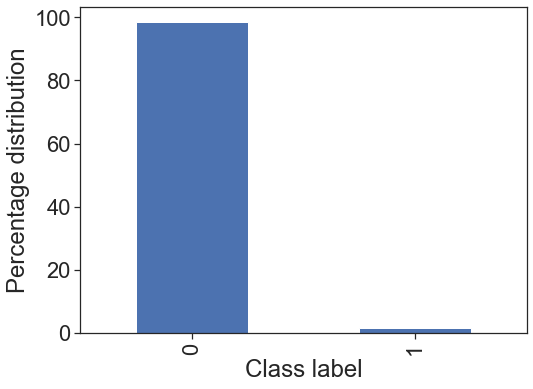

In [33]:
class_dis = (df.FATAL.value_counts()/len(df)*100)
class_dis.plot(kind = 'bar', figsize = (8,6))
plt.xlabel('Class label')
plt.ylabel('Percentage distribution')
round(class_dis,2)

## Reduce the dataset

Since the dataset is very large to fit in a small laptop memory, training the entire dataset on a laptop will take days to run let alone tuning the hyperparameters by grid search.  Hence, we will first split the dataset into two subsets and train the model on the small subset

In [7]:
X1, X2, y1, y2 = train_test_split(df,df.FATAL, test_size = 0.03, random_state = 42, stratify = df.FATAL)

In [8]:
print('Large subset size:', X1.shape, y1.shape)
print('Small subset size:', X2.shape, y2.shape)

Large subset size: (3703084, 23) (3703084,)
Small subset size: (114529, 23) (114529,)


In [9]:
# Pickle the small subset
X2.to_pickle('../data/collision.pkl')

# Prepare the Reduced Data Set for Machine Learning

In [10]:
# Reload the small subset
df_small = pd.read_pickle('../data/collision.pkl')

In [11]:
# Feature matrix and class label
X, y = df_small.drop(['P_ID', 'V_ID', 'FATAL'], axis = 1), df_small['FATAL']

In [12]:
print('Data size:', X.shape, y.shape)

Data size: (114529, 20) (114529,)


## 1. Create a Test Set

We now split the data set into $80\%$ training set and $20\%$ test set in a stratify fashion

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)

In [14]:
print('Training set size:', X_train.shape, y_train.shape)
print('Test set size:', X_test.shape, y_test.shape)

Training set size: (91623, 20) (91623,)
Test set size: (22906, 20) (22906,)


In [15]:
print('Training set class distribution:\n', (y_train.value_counts()/X_train.shape[0])*100)
print('*********************************')
print('Test set class distribution:\n', (y_test.value_counts()/X_test.shape[0])*100)

Training set class distribution:
 0    98.394508
1     1.605492
Name: FATAL, dtype: float64
*********************************
Test set class distribution:
 0    98.393434
1     1.606566
Name: FATAL, dtype: float64


## 2. Data Pre-processing

In [17]:
# List of categorical attributes
cat_subset = list(X_train.select_dtypes('O'))

# List of numerical attributes
num_subset = list(X_train.select_dtypes('number'))

# Binarize the categorical attributes
cat_attribs = [([cat], LabelBinarizer()) for cat in cat_subset]

# Power transform and Standardize the numerical attributes
num_attribs = [([num], PowerTransformer()) for num in num_subset]

# Build a dataframe mapper pipeline
mapper = DataFrameMapper(cat_attribs + num_attribs, df_out = True)

# Fit transform the training set
X_train_scaled = mapper.fit_transform(X_train)

# Only transform the training set
X_test_scaled = mapper.transform(X_test)

In [73]:
# Size of the data after pre-processing
print('Training set size after pre-processing:', X_train_scaled.shape)
print('Test set size after pre-processing:', X_test_scaled.shape)

Training set size after pre-processing: (91623, 131)
Test set size after pre-processing: (22906, 131)


In [74]:
# Convert the class labels to arrays
y_train, y_test = y_train.values,  y_test.values

# A. Model Selection by Cross-Validation Predictions

In this section, we train three models on the imbalanced dataset: 

1). Logistic Regression

2). Random Forest classifier

3). XGBoost classifier

As we shall see below, the overall accuracy of the model is not a good  performance measure for the imbalanced datasets as it is bias towards the majority (negative) class. Therefore, we shall select and optimize the model with the best area under the receiver operating charateristics curve (AUROC) and the precision-recall (AUPR) curve. 

## A-1. Logistic Regression

In [75]:
log_clf = LogisticRegression()                         
model_selection_cv(log_clf, X_train_scaled, y_train, cv_fold = 5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.990177 (0.000367)
AUROC: 0.887189
AUPRC: 0.537292
Predicted classes: [0 1]
Confusion matrix:
 [[90142    10]
 [  890   581]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     90152
           1       0.98      0.39      0.56      1471

    accuracy                           0.99     91623
   macro avg       0.99      0.70      0.78     91623
weighted avg       0.99      0.99      0.99     91623

****************************************************************************


## A-2. Random Forest Classifier

In [76]:
rf_clf = RandomForestClassifier(random_state = 42)                         
model_selection_cv(rf_clf, X_train_scaled, y_train, cv_fold = 5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.990068 (0.000365)
AUROC: 0.777278
AUPRC: 0.456623
Predicted classes: [0 1]
Confusion matrix:
 [[90150     2]
 [  908   563]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     90152
           1       1.00      0.38      0.55      1471

    accuracy                           0.99     91623
   macro avg       0.99      0.69      0.77     91623
weighted avg       0.99      0.99      0.99     91623

****************************************************************************


## A-3. XGBoost

In [77]:
xgb_model = xgb.XGBClassifier(random_state = 42)
model_selection_cv(xgb_model, X_train_scaled, y_train, cv_fold = 5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.990188 (0.000255)
AUROC: 0.893573
AUPRC: 0.540993
Predicted classes: [0 1]
Confusion matrix:
 [[90150     2]
 [  897   574]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     90152
           1       1.00      0.39      0.56      1471

    accuracy                           0.99     91623
   macro avg       0.99      0.70      0.78     91623
weighted avg       0.99      0.99      0.99     91623

****************************************************************************


# B.  Hyperparameter Tuning and Cost Sensitive Method
 In this section, we shall optimize the **AUC** of the classifiers using grid/randomized search, cross-validation, and cost sensitive method

In [78]:
# Class ratio of the negative class to the positive class
neg = y_train == 0
pos = y_train == 1
class_ratio = np.sum(neg)/np.sum(pos)
class_ratio

61.28619986403807

## B-1. Logistic Regression

In [79]:
# Range of hyperparameters
param_grid = {'C': [2**(-5), 2**(-3), 2**(-1), 2**(0), 2**(1)], 
             'class_weight': ['balanced', {0:1, 1:2}, {0:1, 1:3}]}
                             
# Grid search
gsearch_log = GridSearchCV(LogisticRegression(),param_grid, cv = 5,
                           scoring = 'roc_auc',verbose =1, n_jobs = -1)

# Fit the  training set
gsearch_log.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(gsearch_log.best_estimator_, '../trained_models/log_clf.pkl')

# Print results
print('Grid search best AUC score:', gsearch_log.best_score_)
print('Grid search best parameters:', gsearch_log.best_params_)    

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.3min finished


Grid search best AUC score: 0.8884458502195157
Grid search best parameters: {'C': 0.03125, 'class_weight': 'balanced'}


## B-2. Random Forest

In [80]:
# Range of hyperparameters
params = {'max_features': [1, 0.5, 'sqrt', 'log2'], 
          'class_weight': ['balanced', 'balanced_subsample',
          {0: 1, 1: 2}, {0: 1, 1: class_ratio}]}

# Randomized search
rf_clf = RandomForestClassifier(n_estimators = 2000, min_samples_leaf = 10, random_state = 42)           
rsearch_rf = RandomizedSearchCV(estimator = rf_clf, param_distributions = params, 
                                scoring = 'roc_auc', cv = 5, n_jobs = -1, 
                                random_state = 42, verbose = 1)  
# Fit the  training set                                                    
rsearch_rf.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_rf.best_estimator_, '../trained_models/rf_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_rf.best_score_) 
print('Randomized search best hyperparameters:', rsearch_rf.best_params_) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 261.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 287.7min finished


Randomized search best AUC score: 0.8957037637489631
Randomized search best hyperparameters: {'max_features': 'sqrt', 'class_weight': {0: 1, 1: 61.28619986403807}}


Text(0.5, 1.0, 'Top 10 important features')

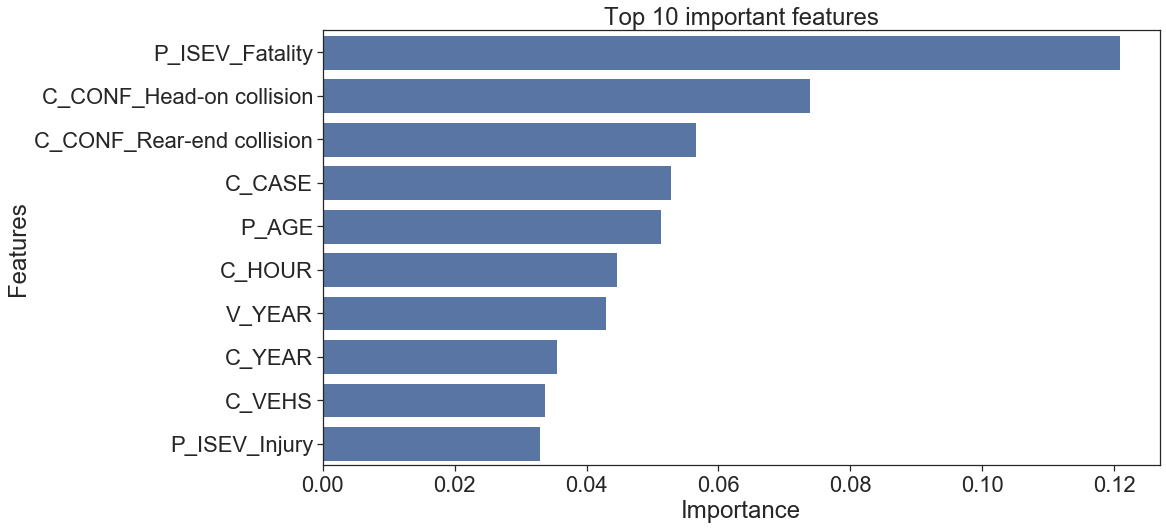

In [32]:
# Figure size
plt.figure(figsize = (15,8))
sns.set(font_scale = 2)
sns.set_style('ticks')

# Load trained model
rf_clf = joblib.load('../trained_models/rf_clf.pkl')

# Compute feature importance
importances = rf_clf.feature_importances_
features = X_train_scaled.columns
importances_df = pd.DataFrame({'Features': features, 'Importance': importances})
importances_df = importances_df.sort_values('Importance', ascending = False)

# Bar plot
sns.barplot(data = importances_df.head(10),  x = 'Importance', y = 'Features', color = 'b')
plt.title('Top 10 important features')

## B-3. XGBoost

In [81]:
# Range of hyperparameters
params = {'subsample':[i/10 for i in range(5,9)],'colsample_bytree': [i/10 for i in range(5,9)]}

# Randomized search
xgb_model = xgb.XGBClassifier(n_estimators = 2000, random_state = 42,
                              scale_pos_weight = class_ratio, learning_rate = 0.1, 
                              min_child_weight = 5, max_depth = 9)
rsearch_xgb = RandomizedSearchCV(estimator = xgb_model, param_distributions = params, 
                                  scoring = 'roc_auc', cv = 5, n_jobs = -1, 
                                  random_state = 42, verbose = 1)  
# Fit the  training set                                                            
rsearch_xgb.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_xgb.best_estimator_, '../trained_models/xgb_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_xgb.best_score_) 
print('Randomized search best hyperparameters:', rsearch_xgb.best_params_) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 450.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 528.7min finished


Randomized search best AUC score: 0.8619470141910228
Randomized search best hyperparameters: {'subsample': 0.6, 'colsample_bytree': 0.5}


# C. Resampling Methods

In this section, we will employ two resampling techniques on the training set to balance the classes. However, the final prediction will be made on the imbalanced test set. The idea of resampling is to trick the classifier using a balanced dataset.  

## C-1. Under sampling of the majority class combined with Random Forest Classifier

In undersampling, we reduce the majority class such that it matches the minority class

In [82]:
# Under sample the majority class
und = RandomUnderSampler(ratio = 'majority', random_state = 42)
X_train_scaled_und, y_train_und = und.fit_sample(X_train_scaled, y_train)

In [83]:
print('Undersampled training data size:', X_train_scaled_und.shape, y_train_und.shape)

Undersampled training data size: (2942, 131) (2942,)


In [84]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('Undersampled training set class distribution:', np.bincount(y_train_und))

Imbalanced training set class distribution: [90152  1471]
Undersampled training set class distribution: [1471 1471]


- We can see that the majority class in the training set has been undersampled

- We now have equal class distribution. Note that the test set is not resampled

In [96]:
# Random Forest Classifier cross-validation on the undersampled dataset
rf_und = RandomForestClassifier(n_estimators = 1000,random_state = 42)
model_selection_cv(rf_und, X_train_scaled_und, y_train_und, cv_fold = 5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.795713 (0.011008)
AUROC: 0.890071
AUPRC: 0.906710
Predicted classes: [0 1]
Confusion matrix:
 [[1254  217]
 [ 384 1087]]
Classification report:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81      1471
           1       0.83      0.74      0.78      1471

    accuracy                           0.80      2942
   macro avg       0.80      0.80      0.80      2942
weighted avg       0.80      0.80      0.80      2942

****************************************************************************


## C-2. Synthetic Minority Over Sampling Technique (SMOTE)  with Random Forest Classifier

In SMOTE, we generate synthetic oberservations to match the minority class

In [86]:
# Over sample the minority class
sm = SMOTE(ratio = 'minority', random_state = 42)
X_train_scaled_ovsm, y_train_ovsm = sm.fit_sample(X_train_scaled, y_train)

In [87]:
print('SMOTE training data size:', X_train_scaled_ovsm.shape, y_train_ovsm.shape)

SMOTE training data size: (180304, 131) (180304,)


In [88]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('SMOTE resampled training set class distribution:', np.bincount(y_train_ovsm))

Imbalanced training set class distribution: [90152  1471]
SMOTE resampled training set class distribution: [90152 90152]


- Similarly,  SMOTE oversampled the minority class in the training set, so we now have equal class distribution. 

In [89]:
# Random Forest cross-validation on the SMOTE dataset
rf_ovsm = RandomForestClassifier(random_state = 42)
model_selection_cv(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, cv_fold=5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.995047 (0.008879)
AUROC: 0.998837
AUPRC: 0.998847
Predicted classes: [0 1]
Confusion matrix:
 [[90108    44]
 [  849 89303]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     90152
           1       1.00      0.99      1.00     90152

    accuracy                           1.00    180304
   macro avg       1.00      1.00      1.00    180304
weighted avg       1.00      1.00      1.00    180304

****************************************************************************


## C-3. ROC and PR Curves on the Cross-Validation Training Set
We can see that SMOTE performed extremely well on the training set

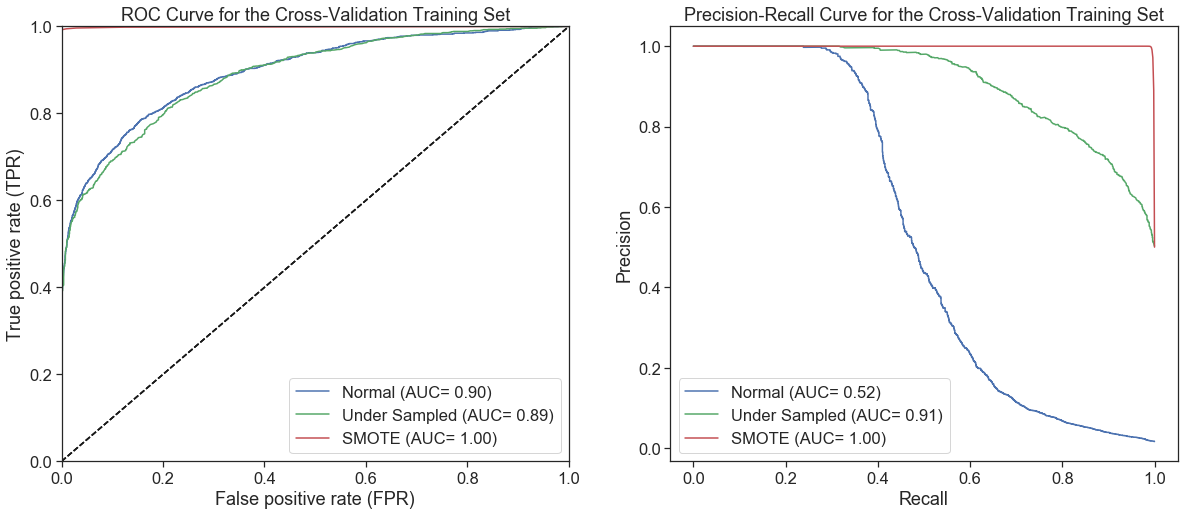

In [97]:
# Set figure and font sizes
fig = plt.figure(figsize = (20,8))
plt.rcParams.update({'font.size':20})
sns.set(font_scale = 1.5)
sns.set_style('ticks')

# Plot ROC and PR curves for normal imbalanced distribution
Plot_ROC_Curve_and_PRC_Cross_Val(rsearch_rf.best_estimator_, X_train_scaled, y_train,
                       color= 'b', label = 'Normal (AUC= %0.2f)')

# Plot ROC and PR curves for Under Sampled distribution
Plot_ROC_Curve_and_PRC_Cross_Val(rf_und, X_train_scaled_und, y_train_und,
                       color= 'g', label = 'Under Sampled (AUC= %0.2f)')
                     
# Plot ROC and PR curves for SMOTE distribution
Plot_ROC_Curve_and_PRC_Cross_Val(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm,
                       color= 'r', label = 'SMOTE (AUC= %0.2f)') 

# D. Prediction on the Imbalanced Test Set 
In this section, we make our final prediction on the imbalanced dataset after training the model using the resampling techniques.

## D-1. Normal Imbalanced dataset

In [91]:
rf_best = rsearch_rf.best_estimator_
Test_Prediction(rf_best, X_train_scaled, y_train, X_test_scaled, y_test)

****************************************************************************
Test accuracy:  0.978172
AUROC: 0.895981
AUPRC: 0.524730
Predicted classes: [0 1]
Confusion matrix:
 [[22205   333]
 [  167   201]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     22538
           1       0.38      0.55      0.45       368

    accuracy                           0.98     22906
   macro avg       0.68      0.77      0.72     22906
weighted avg       0.98      0.98      0.98     22906

****************************************************************************


## D-2. Undersampled dataset

In [98]:
Test_Prediction(rf_und, X_train_scaled_und, y_train_und, X_test_scaled, y_test)

****************************************************************************
Test accuracy:  0.855496
AUROC: 0.896101
AUPRC: 0.491959
Predicted classes: [0 1]
Confusion matrix:
 [[19321  3217]
 [   93   275]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92     22538
           1       0.08      0.75      0.14       368

    accuracy                           0.86     22906
   macro avg       0.54      0.80      0.53     22906
weighted avg       0.98      0.86      0.91     22906

****************************************************************************


## D-3. SMOTE dataset

In [93]:
Test_Prediction(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test)

****************************************************************************
Test accuracy:  0.990134
AUROC: 0.779037
AUPRC: 0.476547
Predicted classes: [0 1]
Confusion matrix:
 [[22525    13]
 [  213   155]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     22538
           1       0.92      0.42      0.58       368

    accuracy                           0.99     22906
   macro avg       0.96      0.71      0.79     22906
weighted avg       0.99      0.99      0.99     22906

****************************************************************************


## D-4. ROC and PR Curves on the Test Set
The AUPRC of the normal imbalanced dataset is slightly higher (by 0.01%) than undersampling and SMOTE.

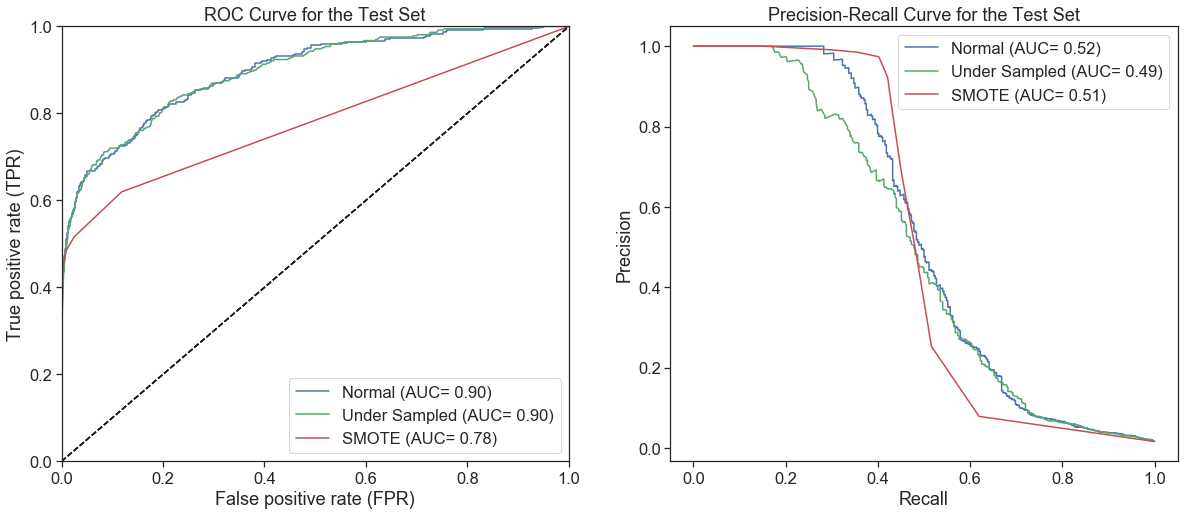

In [99]:
# Set figure and font sizes
fig = plt.figure(figsize = (20,8))
plt.rcParams.update({'font.size':20})
sns.set(font_scale = 1.5)
sns.set_style('ticks')

# Plot ROC and PR curves for normal imbalanced distribution
Plot_ROC_Curve_and_PRC(rsearch_rf.best_estimator_, X_train_scaled, y_train, X_test_scaled, y_test,
                       color= 'b', label = 'Normal (AUC= %0.2f)')

# Plot ROC and PR curves for Under Sampled distribution
Plot_ROC_Curve_and_PRC(rf_und, X_train_scaled_und, y_train_und, X_test_scaled, y_test,
                       color= 'g', label = 'Under Sampled (AUC= %0.2f)')

# Plot ROC and PR curves for  SMOTE distribution
Plot_ROC_Curve_and_PRC(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test,
                       color= 'r', label = 'SMOTE (AUC= %0.2f)')